In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image 
from IPython.display import display 
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchsummary
import numpy as np
from collections import namedtuple

import copy
import time
import glob
import re
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Download COCO Dataset - http://images.cocodataset.org/zips/val2017.zip

some differences:

Original paper: COCO 2014 train --> 80000 images & 13GB

My implementation: COCO 2017 val --> 5000 images / 1GB --> x16 epochs

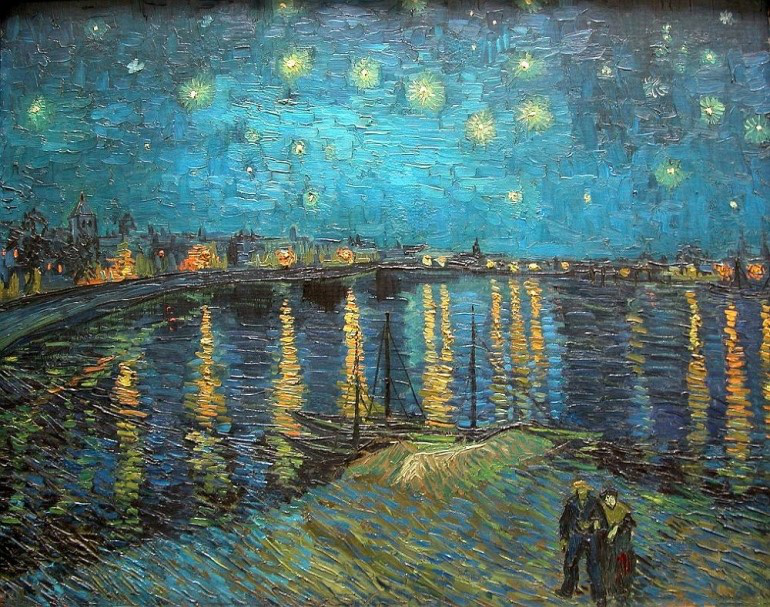

In [4]:
style_image_location = "/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/style_image.jpg" #FIXME

style_image_sample = Image.open(style_image_location, 'r')
display(style_image_sample)

In [0]:
batch_size = 8
random_seed = 10
num_epochs = 150 
initial_lr = 1e-3
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/" #FIXME

content_weight = 1e5
style_weight = 1e10
log_interval = 50
checkpoint_interval = 500

running_option = "test" #FIXME 
#running_option = "test_video" #FIXME
#running_option = "training" #FIXME

In [0]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        print("vgg_pretrained_features : ")
        print(vgg_pretrained_features)
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters(): ##self.parameter -> vgg16의 파라미터 
                print(param)
                param.requires_grad = False
        #print("parameters : ")
        #print(self.parameters())

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out


In [0]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__() 
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [0]:
class ResidualBlock(nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

In [0]:
class UpsampleConvLayer(nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [0]:
class TransformerNet(nn.Module):
  ## image size 작아졌다가 다시 원상태로 커짐 == chanel 커졋다가 작아짐  -> 이미지 변환   ,중간에 residual block => cyclegan의 genertaor부분과 똑같다 
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.encoder = nn.Sequential()
        
        self.encoder.add_module('conv1', ConvLayer(3, 32, kernel_size=9, stride=1))
        self.encoder.add_module('in1', nn.InstanceNorm2d(32, affine=True)) ## 인스턴트 정규화 한다~ 
        self.encoder.add_module('relu1', nn.ReLU())
        
        self.encoder.add_module('conv2', ConvLayer(32, 64, kernel_size=3, stride=2))
        self.encoder.add_module('in2', nn.InstanceNorm2d(64, affine=True))
        self.encoder.add_module('relu2', nn.ReLU())
        
        self.encoder.add_module('conv3', ConvLayer(64, 128, kernel_size=3, stride=2))
        self.encoder.add_module('in3', nn.InstanceNorm2d(128, affine=True))
        self.encoder.add_module('relu3', nn.ReLU())

        # Residual layers
        self.residual = nn.Sequential()
        
        for i in range(5):
          self.residual.add_module('resblock_%d' %(i+1), ResidualBlock(128))
        
        # Upsampling Layers
        self.decoder = nn.Sequential()
        self.decoder.add_module('deconv1', UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2))
        self.decoder.add_module('in4', nn.InstanceNorm2d(64, affine=True))
        self.encoder.add_module('relu4', nn.ReLU())

        self.decoder.add_module('deconv2', UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2))
        self.decoder.add_module('in5', nn.InstanceNorm2d(32, affine=True))
        self.encoder.add_module('relu5', nn.ReLU())

        self.decoder.add_module('deconv3', ConvLayer(32, 3, kernel_size=9, stride=1))


    def forward(self, x):
        encoder_output = self.encoder(x)
        residual_output = self.residual(encoder_output)
        decoder_output = self.decoder(residual_output)
        
        return decoder_output

In [0]:
# Video Capture Sanity Check
cap = cv2.VideoCapture("/content/gdrive/My Drive/Colab_Notebooks/data/mirama_demo.mp4")

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = frame[:,:,::-1]
    
    print(frame.shape)
    
    plt.imshow(frame)
    
    break
cap.release()
cv2.destroyAllWindows()

In [0]:
""" Util Functions """
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img
    

def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    display(img)
    img.save(filename)

def post_process_image(data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    #img = Image.fromarray(img)
    
    return img
    

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

In [13]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
])

print(glob.glob("/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/*"))

train_dataset = datasets.ImageFolder("/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/", transform) #FIXME
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

['/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463037.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463174.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463283.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463522.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463527.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463730.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463647.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463542.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val2017/000000463618.jpg', '/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/val2017/val201

In [14]:
transformer = TransformerNet()
vgg = VGG16(requires_grad=False).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:33<00:00, 16.6MB/s]


vgg_pretrained_features : 
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17):

In [0]:
optimizer = torch.optim.Adam(transformer.parameters(), initial_lr)
mse_loss = nn.MSELoss()

style = load_image(filename=style_image_location, size=None, scale=None)
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1).to(device)

features_style = vgg(normalize_batch(style))
gram_style = [gram_matrix(y) for y in features_style]

In [0]:
transfer_learning = True # inference or training first --> False / Transfer learning --> True
ckpt_model_path = os.path.join(checkpoint_dir, "ckpt_epoch_137_batch_id_500.pth") #FIXME

if transfer_learning:
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  transformer.load_state_dict(checkpoint['model_state_dict'])
  transformer.to(device)

In [0]:
if running_option == "training":
  transformer.cuda()
  if transfer_learning:
      transfer_learning_epoch = checkpoint['epoch'] 
  else:
      transfer_learning_epoch = 0

  for epoch in range(transfer_learning_epoch, num_epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0

        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device) #cuda로 돌린다 이거
            y = transformer(x) ## x의 사진이 변화된 것이 y 

            y = normalize_batch(y) ##배치정규화 
            x = normalize_batch(x) ##배치정규화

            features_y = vgg(y) ##배치정규화된 y를 out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
            features_x = vgg(x) ##원래 사진 정규화 한것을 out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)

            content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2) ##content->원래 사진 loss 

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style): ##feature y 가 h_relu1_2~~ 4개니까 각각 loss 다 더함 
                gm_y = gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :]) 
            style_loss *= style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), epoch + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if checkpoint_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
                transformer.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(epoch) + "_batch_id_" + str(batch_id + 1)  + ".pth"
                print(str(epoch), "th checkpoint is saved!")
                ckpt_model_path = os.path.join(checkpoint_dir, ckpt_model_filename)
                torch.save({
                'epoch': epoch,
                'model_state_dict': transformer.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss
                }, ckpt_model_path)

                transformer.to(device).train()  

Mon Dec  2 05:44:29 2019	Epoch 106:	[400/5000]	content: 298078.396875	style: 76369.981250	total: 374448.378125
Mon Dec  2 05:48:26 2019	Epoch 106:	[800/5000]	content: 297302.232500	style: 76090.193984	total: 373392.426484
Mon Dec  2 05:52:29 2019	Epoch 106:	[1200/5000]	content: 295408.668542	style: 75740.275885	total: 371148.944427
Mon Dec  2 05:56:29 2019	Epoch 106:	[1600/5000]	content: 296848.171484	style: 75723.933789	total: 372572.105273
Mon Dec  2 06:00:29 2019	Epoch 106:	[2000/5000]	content: 296461.386562	style: 75548.783203	total: 372010.169766
Mon Dec  2 06:04:42 2019	Epoch 106:	[2400/5000]	content: 296391.798177	style: 75423.852721	total: 371815.650898
Mon Dec  2 06:08:45 2019	Epoch 106:	[2800/5000]	content: 296580.092902	style: 75358.259074	total: 371938.351975
Mon Dec  2 06:13:02 2019	Epoch 106:	[3200/5000]	content: 297038.800312	style: 75347.286807	total: 372386.087119
Mon Dec  2 06:17:09 2019	Epoch 106:	[3600/5000]	content: 297108.701458	style: 75224.508160	total: 372333.2

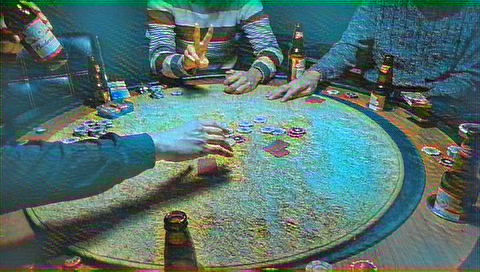

In [20]:
if running_option == "test":
    content_image = load_image("/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/test6.jpg", scale=2) #FIXME
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        style_model = TransformerNet()
        
        ckpt_model_path = os.path.join(checkpoint_dir, "ckpt_epoch_137_batch_id_500.pth") #FIXME
        checkpoint = torch.load(ckpt_model_path, map_location=device)
        
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(checkpoint.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del checkpoint[k]
        
        style_model.load_state_dict(checkpoint['model_state_dict'])
        style_model.to(device)
        
        output = style_model(content_image).cpu()
        
    save_image("/content/gdrive/My Drive/Colab Notebooks/fast_style_transfer_data/test6_137.png", output[0]) #FIXME

In [0]:
if running_option == "test_video":
    
    with torch.no_grad():
        style_model = TransformerNet()

        ckpt_model_path = os.path.join(checkpoint_dir, "ckpt_epoch_63_batch_id_500.pth") #FIXME
        checkpoint = torch.load(ckpt_model_path, map_location=device)

        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(checkpoint.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del checkpoint[k]

        style_model.load_state_dict(checkpoint['model_state_dict'])
        style_model.to(device)

        cap = cv2.VideoCapture("/content/gdrive/My Drive/Colab_Notebooks/data/mirama_demo.mp4") #FIXME

        frame_cnt = 0
        
        fourcc = cv2.VideoWriter_fourcc(*'XVID') 
        out = cv2.VideoWriter('/content/gdrive/My Drive/Colab_Notebooks/data/mirama_demo_result.avi', fourcc, 60.0, (1920,1080)) #FIXME

        
        while(cap.isOpened()):
            ret, frame = cap.read()
            
            try:
              frame = frame[:,:,::-1] - np.zeros_like(frame)
            except:
              break
              
            print(frame_cnt, "th frame is loaded!")

            content_image = frame
            content_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.mul(255))
            ])
            content_image = content_transform(content_image)
            content_image = content_image.unsqueeze(0).to(device)

            output = style_model(content_image).cpu()
            #save_image("/content/gdrive/My Drive/Colab_Notebooks/data/vikendi_video_result/" + str(frame_cnt) +".png", output[0]) #FIXME
            out.write(post_process_image(output[0]))
            frame_cnt += 1
            

        cap.release()
        out.release()
        cv2.destroyAllWindows()
  
